# Extract bubble from simulations

In [2]:
import numpy as np
import scipy as scp
import scipy.optimize as sco
import math
import statistics as stat
import matplotlib.pyplot as plt

### Simulation Parameters 

In [3]:
nLat = 512
nSims = 50
tMax = 20000

nu = 2.*10**(-3); print('V_0 = ', 4*nu)
lamb = 6; print('lamb = ', lamb)
m2eff = 4. * nu * (- 1. + lamb**2); print('m2eff = ', m2eff)
len0 = 10. / np.sqrt(2. * nu); print('lenLat = ', len0)

paramL = np.arange(5, 7, 1)
paramP = np.arange(8, 11, 1)
phiMax = 1.59858
AA = 10
ppp = 3

V_0 =  0.008
lamb =  6
m2eff =  0.28
lenLat =  158.11388300841898


### Extract data from files

In [4]:
suffix = '_for_lamb{:.4f}'.format(lamb)+'_x'+str(nLat)
plots_file = '/home/dpirvu/big_plot_file/non_osc_thin_wall_average_bubble/'
pickle_file = '/home/dpirvu/pickle_location/non_osc_thin_wall_average_bubble/'
sims_file = '/gpfs/dpirvu/sims/'

def V(phi):
    if phi > phiMax:
        potential = - np.cos(phi) + 0.5 * lamb**2 * np.sin(phi)**2
    else:
        V0 = - np.cos(phiMax) + 0.5 * lamb**2 * np.sin(phiMax)**2
        potential = V0 + AA / ppp * np.abs(phi - phiMax)**ppp
    return potential# * 4 * nu

def sim_location(sim, pot_type, length, phi0):
    return sims_file+'typeP'+str(pot_type)+'_len{:.4f}'.format(length)+'_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)+'_x'+str(nLat)+'_sim'+str(sim)+'_fields.dat'

def extract_data(filename, col):
#    print(filename)
    file = open(filename,'r')
    lines = file.readlines()
    lines = [line.replace('\x00','') for line in lines[3:]]
    field_values = [float(line.split()[col]) for line in lines[:]]
    file.close()
    return field_values

def get_threshold(all_data, ns):
#    coss = [stat.mean([np.cos(i) for i in all_data[sim][0]]) for sim in range(len(all_data))]
    coss = [stat.mean([i for i in all_data[sim][0]]) for sim in range(len(all_data))]
    ct, deltact = stat.mean(coss), stat.stdev(coss)
    print('ct, deltact: ', ct, deltact)
    return ct + ns * deltact

def decay_time(bubble, threshold):
    cosslice = [stat.mean(np.cos(slice)) for slice in bubble[::-1]]
    T = len(bubble)
    return next((T-1-t for t in range(len(cosslice)) if cosslice[t] < threshold), 0)

def import_sim(sim, pot_type, length, phi0):
    data = extract_data(sim_location(sim, pot_type, length, phi0), 0)
    nT = len(data)//nLat
    data = np.reshape(data, (nT, nLat))
    return data
 #   newphase = sum([1 for x in np.cos(data[-1]) > np.cos(phi_upper_bound)])
 #   if newphase > 50:
 #       return data

def cut_bubbles(all_data, ns, duration):
    return_data, sims_to_keep, sim_time = [], [], []
    threshold = get_threshold(all_data, ns)
#    print('threshold: ', threshold)
    for sim in range(len(all_data)):
        tcut = decay_time(all_data[sim], threshold)
        if tcut > 0:
            return_data.append(all_data[sim][max((tcut-duration, 0)):tcut+duration])
            sims_to_keep.append(sim)
            sim_time.append(tcut)
#            print('sim =', sim, ', tcut =', tcut)
    return return_data, sims_to_keep, sim_time

def get_bubbles_durations(all_data, ns, duration):
    sim_time = []
    threshold = get_threshold(all_data[::int(len(all_data)//10)], ns)
    print('threshold: ', threshold)
    for sim in range(len(all_data)):
        tcut = decay_time(all_data[sim], threshold)
        sim_time.append(tcut)
    return sim_time

def plot_all_data(sim, typeP, tmax):
    fig, ax = plt.subplots(1, 1, figsize = (8, 5))
    im0 = ax.imshow(all_data[sim][:tmax], aspect='auto', interpolation='none', origin='lower')
    clb = plt.colorbar(im0, ax = ax); ax.set_title('potential type '+str(typeP)); ax.set(xlabel = r'$x$', ylabel = r'$t$'); plt.show()
    return

def plot_simulation(simulation, tmax):
    fig, ax = plt.subplots(1, 1, figsize = (8, 5))
    im0 = ax.imshow(simulation[:tmax], aspect='auto', interpolation='none', origin='lower')
    clb = plt.colorbar(im0, ax = ax); ax.set_title('potential type '+str(typeP)); ax.set(xlabel = r'$x$', ylabel = r'$t$'); plt.show()
    return

def plot_V(all_data):
    fig = plt.figure(figsize=(7, 4))
    xlist = np.arange(0, 3*np.pi, np.pi/100)
    for simulation in all_data:
        fluct0, fluct = stat.mean(simulation[0]), stat.mean(simulation[0])
        fluctr0 = fluct0 + stat.stdev(simulation[0])
        plt.plot(fluct0, V(fluct0), 'ro', fluctr0, V(fluctr0), 'bo')
    plt.plot(xlist, [V(i) for i in xlist])
    plt.xlabel(r'$\phi(x)$'); plt.ylabel(r'$V(\phi(x))$'); plt.show()

In [5]:
typeP = 1

for pP in paramP:
#    phi0 = paramP[1]/10; print(phi0)
    phi0 = pP/10; print(phi0)
    lenLat = paramL[0]*len0; print(lenLat)
    ns = paramL[0]
    duration = 50

    all_data = [import_sim(sim, typeP, lenLat, phi0) for sim in range(nSims)]
    #plot_V(all_data)
    all_data, sims_to_keep, durations = cut_bubbles(all_data, ns, duration)

0.8
790.5694150420949
ct, deltact:  3.1413601826908812 0.0019468307271003277
0.9
790.5694150420949
ct, deltact:  3.1413805790368445 0.0013947128841899448
1.0
790.5694150420949
ct, deltact:  3.1414273695634685 0.00107924101518904


In [14]:
vec = [0.0019468307271003277, 0.0013947128841899448, 0.00107924101518904]

In [16]:
np.mean(vec * paramP/10)

0.0012973157308800842

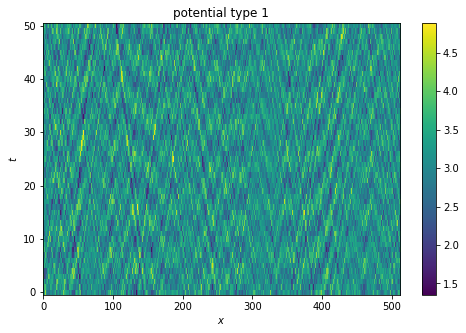

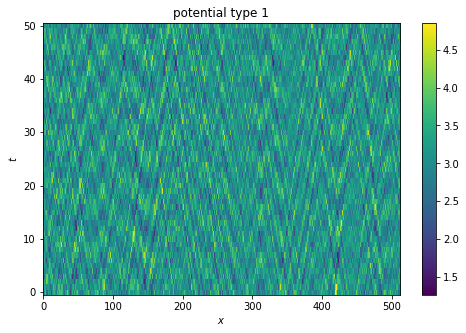

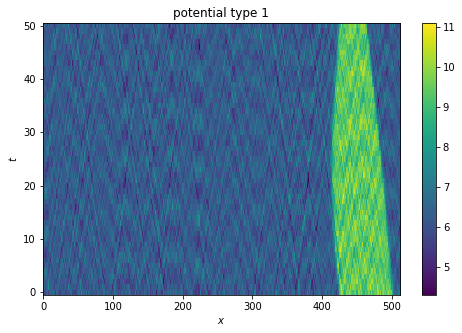

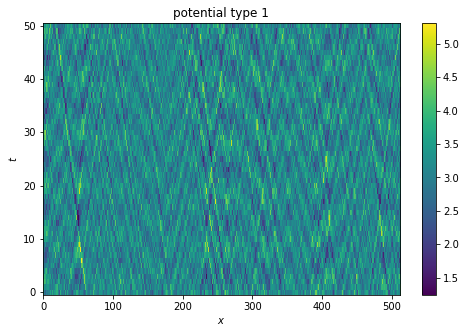

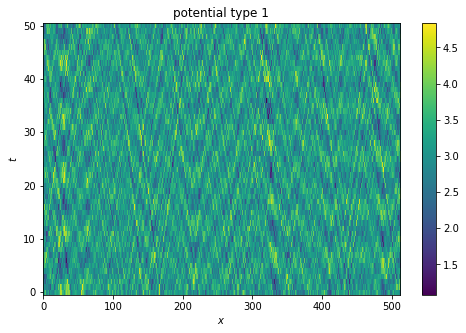

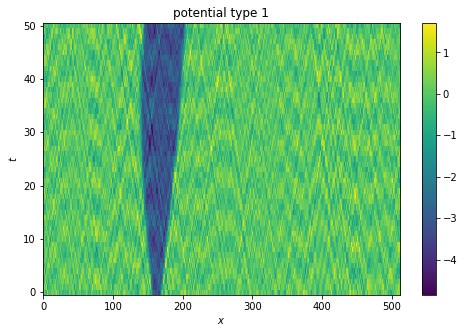

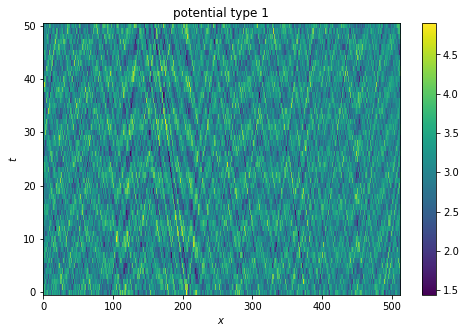

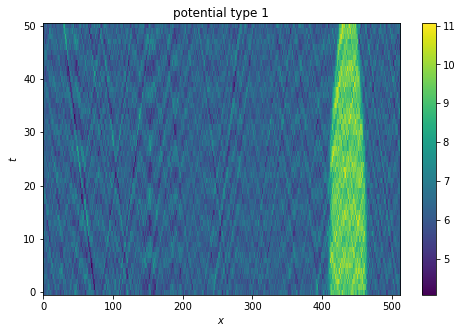

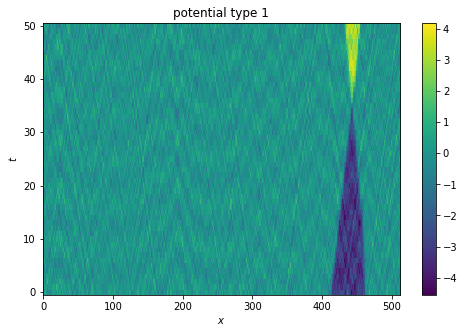

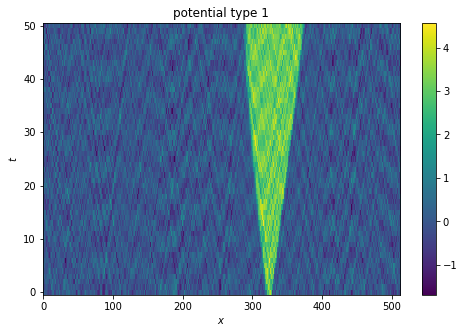

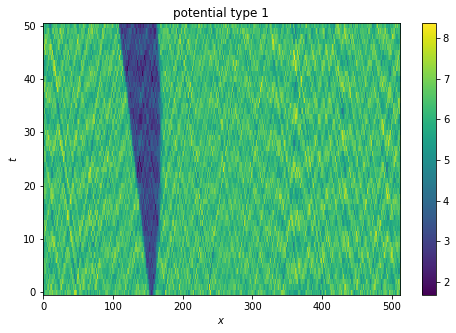

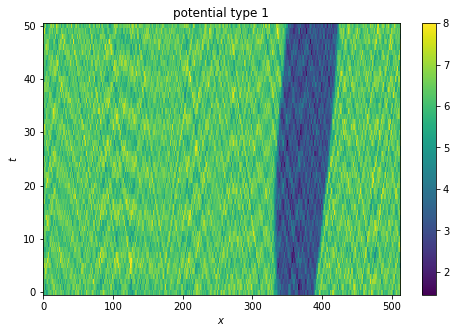

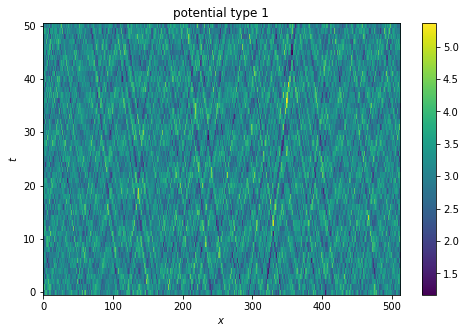

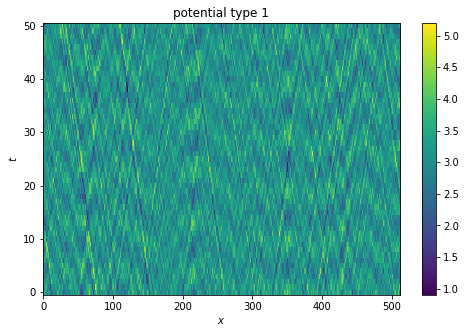

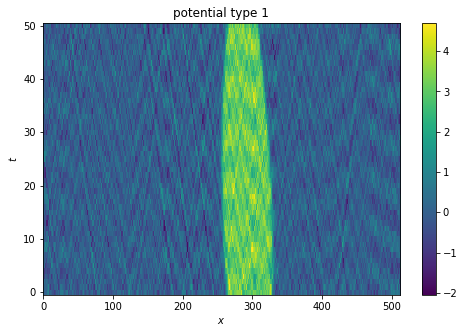

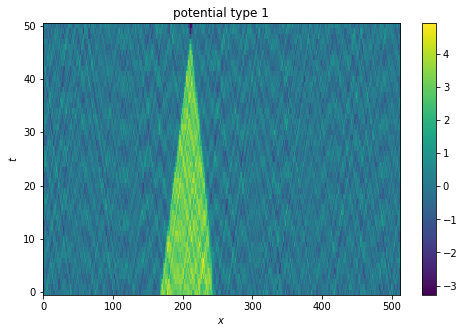

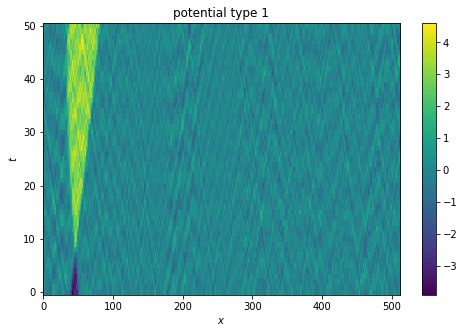

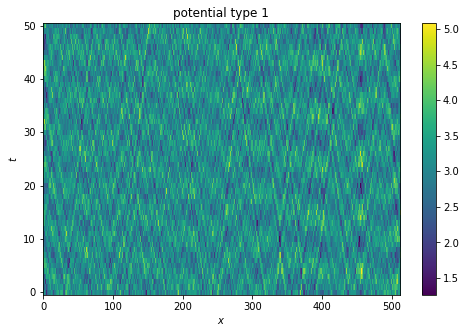

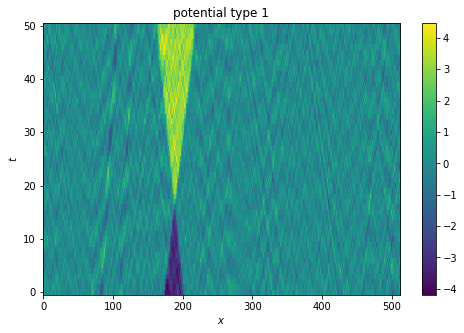

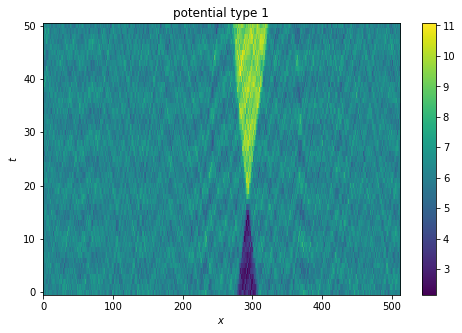

In [5]:
for sim in range(len(all_data)):
    plot_all_data(sim, typeP, None)

In [6]:
def decay_exp(t, t0, gamma):
    return np.exp(- gamma * (t - t0))

def decay(t, t0, gamma):
    return - gamma * (t - t0)

def fit_decay_exp(axis, Fsurv):
    plt.plot(axis, Fsurv, 'ro')
    popt, pcov = sco.curve_fit(decay, axis, Fsurv)
    plt.plot(axis, [decay_exp(t, *popt) for t in axis], 'g')
    plt.show()
    return popt

def fit_decay(axis, Fsurv):
    plt.plot(axis, Fsurv, 'ro')
    popt, pcov = sco.curve_fit(decay, axis, Fsurv)
    plt.plot(axis, [decay(t, *popt) for t in axis], 'g')
    plt.show()
    return popt

ct, deltact:  3.1407417696107967 0.0023372383086245805
threshold:  3.1524279611539194


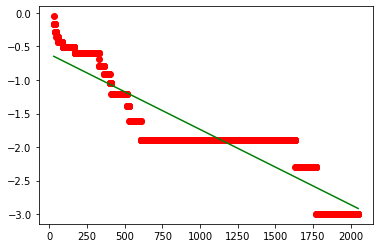

[0.0011219923866960916, 0.8, 790.5694150420949]
ct, deltact:  3.1414182777815043 0.001575222162617103
threshold:  3.1492943885945897


KeyboardInterrupt: 

In [7]:
time_list = np.arange(tMax)
duration = 50

popt_list = []
for typeP in [1,6]:
    popt_list.append([])
    for pL in paramL[:]:
        lenLat = pL*len0
        ns = pL

        popt_list[-1].append([])
        for pP in paramP[:]:
            phi0 = pP / 10.

            all_data = [import_sim(sim, typeP, lenLat, phi0) for sim in range(nSims)]
            durations = get_bubbles_durations(all_data, ns, duration)
            Fsurv = [1. - len([i for i in durations if i < time])/nSims for time in time_list]
            xlist = [t for t in range(len(Fsurv)) if (Fsurv[t] != 0. and Fsurv[t] != 1.)]
#            if len(xlist) > 0:
#                xlist = [x for x in range(max((0, min(xlist)-int(len(Fsurv)//10))), min((max(xlist)+int(len(Fsurv)//10), len(Fsurv))))]
            
            try:
                Fsurv = [np.log(Fsurv[i]) for i in range(len(Fsurv)) if i in xlist]
                time_list = [time_list[i] for i in range(len(time_list)) if i in xlist]
                if len(Fsurv) == 0:
                    popt_list[-1][-1].append([0, phi0, lenLat])
                else:
                    fitparams = fit_decay(time_list, Fsurv)
                    popt_list[-1][-1].append([fitparams[-1], phi0, lenLat])
            except RuntimeError:
                Fsurv = [Fsurv[i] for i in range(len(Fsurv)) if i in xlist]
                time_list = [time_list[i] for i in range(len(time_list)) if i in xlist]
                if len(Fsurv) == 0:
                    popt_list[-1][-1].append([0, phi0, lenLat])
                else:
                    fitparams = fit_decay_exp(time_list, Fsurv)
                    popt_list[-1][-1].append([fitparams[-1], phi0, lenLat])

            np.save(pickle_file+'decay_times.npy', popt_list)
            print(popt_list[-1][-1][-1])

In [ ]:
from itertools import cycle

#popt_list = np.load(pickle_file+'decay_times.npy')
plt.figure(0)
#format: popt_list[typeP][lenLat][phi0]
colors = cycle(('red','blue','orange','green','black'))
for typepot in range(len(popt_list)):
    for typelen in range(len(popt_list[typepot])):
        col = next(colors)
        popt_list[typepot][typelen] = np.asarray(popt_list[typepot][typelen])
        print(popt_list[typepot][typelen])
        plt.semilogy(popt_list[typepot][typelen][:,1]**2., popt_list[typepot][typelen][:,0]*popt_list[typepot][typelen][:,1]**2./(popt_list[typepot][typelen][:,2]*4*nu), '.-', color=col, label='potential '+str(typepot+1))
#        plt.plot(popt_list[typepot][typelen][:,1]**2., popt_list[typepot][typelen][:,0]*popt_list[typepot][typelen][:,1]**2./(popt_list[typepot][typelen][:,2]*4*nu), '.-', color=col, label='potential '+str(typepot+1))
plt.xlabel(r'$\phi_0^2$')
plt.legend()
plt.ylabel(r'$\frac{\phi_{0}^{2}}{V_{0}} \frac{\Gamma}{L}$')
plt.show()